In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# Tải dữ liệu từ tệp Excel
data = pd.read_excel('real_estate_listings.xlsx')

In [4]:
# In danh sách các cột trong tập dữ liệu để kiểm tra thông tin
print("Available columns in dataset:")
for col in data.columns:
    print(f"- {col}")

Available columns in dataset:
- Vị trí
- Giá
- Loại nhà
- Diện tích đất
- Số phòng ngủ
- Số toilet
- Tổng số tầng
- Hướng cửa chính
- Hướng ban công
- Giấy tờ pháp lý


In [5]:
# Hàm chuyển đổi giá từ chuỗi sang số (đơn vị: tỷ đồng)
def convert_price_to_numeric(price_str):
    if pd.isna(price_str):  # Kiểm tra nếu giá trị bị thiếu
        return np.nan

    price_str = str(price_str).strip()  # Chuyển sang chuỗi và loại bỏ khoảng trắng thừa
    
    # Trường hợp giá có đơn vị "tỷ"
    if 'tỷ' in price_str:
        match = re.search(r'(\d+(?:[\.,]\d+)?)\s*tỷ(?:\s*(\d+(?:[\.,]\d+)?)\s*triệu)?', price_str)
        if match:
            billions = float(match.group(1).replace(',', '.'))  # Lấy phần "tỷ"
            millions = 0
            if match.group(2):  # Nếu có cả phần "triệu"
                millions = float(match.group(2).replace(',', '.')) / 1000  # Chuyển triệu thành tỷ
            return billions + millions
    
    # Trường hợp giá có đơn vị "triệu"
    elif 'triệu' in price_str:
        match = re.search(r'(\d+(?:[\.,]\d+)?)\s*triệu', price_str)
        if match:
            return float(match.group(1).replace(',', '.')) / 1000  # Chuyển triệu thành tỷ
    
    # Trường hợp giá đã là số
    try:
        return float(price_str.replace(',', '.'))
    except:
        return np.nan


In [6]:
# Kiểm tra và chuyển đổi cột giá thành dạng số
if 'Giá' in data.columns:
    data['Giá_numeric'] = data['Giá'].apply(convert_price_to_numeric)
else:
    # Tìm cột có thể chứa giá nếu không có cột "Giá"
    price_columns = [col for col in data.columns if 'giá' in col.lower() or 'gia' in col.lower()]
    if price_columns:
        print(f"Using price column: {price_columns[0]}")
        data['Giá_numeric'] = data[price_columns[0]].apply(convert_price_to_numeric)
    else:
        raise ValueError("Không tìm thấy cột giá trong tập dữ liệu")

In [7]:
# Hàm chuyển đổi diện tích từ chuỗi sang số
def convert_area_to_numeric(area_str):
    if pd.isna(area_str):  # Kiểm tra nếu giá trị bị thiếu
        return np.nan
    
    area_str = str(area_str).strip()  # Chuyển sang chuỗi và loại bỏ khoảng trắng
    
    # Trích xuất số từ chuỗi (loại bỏ đơn vị m² hoặc các ký tự khác)
    match = re.search(r'(\d+(?:[\.,]\d+)?)', area_str)
    if match:
        return float(match.group(1).replace(',', '.'))
    
    return np.nan

In [8]:
# Tìm các cột có thể chứa thông tin về diện tích
area_columns = []
for col in data.columns:
    if 'diện tích' in col.lower() or 'dien tich' in col.lower() or 'm²' in str(col).lower():
        area_columns.append(col)

print(f"Found area columns: {area_columns}")


Found area columns: ['Diện tích đất']


In [9]:
# Chuyển đổi các cột diện tích sang dạng số
for col in area_columns:
    if data[col].dtype == 'object':  # Nếu dữ liệu dạng chuỗi
        data[f'{col}_numeric'] = data[col].apply(convert_area_to_numeric)
    else:
        data[f'{col}_numeric'] = data[col]

In [10]:
# Tìm các cột liên quan đến số phòng, số toilet, số tầng
room_columns = []
for col in data.columns:
    if 'phòng' in col.lower() or 'phong' in col.lower():
        room_columns.append(col)
    elif 'toilet' in col.lower() or 'wc' in col.lower():
        room_columns.append(col)
    elif 'tầng' in col.lower() or 'tang' in col.lower():
        room_columns.append(col)

In [11]:
print(f"Found room/toilet/floor columns: {room_columns}")


Found room/toilet/floor columns: ['Số phòng ngủ', 'Số toilet', 'Tổng số tầng']


In [12]:
# Danh sách các cột số sẽ sử dụng cho mô hình
numeric_columns = ['Giá_numeric']  # Bắt đầu với cột giá

In [13]:
# Thêm các cột diện tích đã chuyển đổi
numeric_columns.extend([f'{col}_numeric' for col in area_columns])

# Kiểm tra và thêm các cột số phòng, số tầng nếu có giá trị số hợp lệ
for col in room_columns:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # Chuyển đổi sang dạng số
        if not data[col].isna().all():  # Chỉ sử dụng nếu có giá trị hợp lệ
            numeric_columns.append(col)
    except:
        print(f"Column {col} cannot be converted to numeric, skipping")

In [14]:
# In danh sách cột số sẽ được sử dụng
print("Final numeric columns for model:", numeric_columns)


Final numeric columns for model: ['Giá_numeric', 'Diện tích đất_numeric', 'Tổng số tầng']


<Figure size 1800x1500 with 0 Axes>

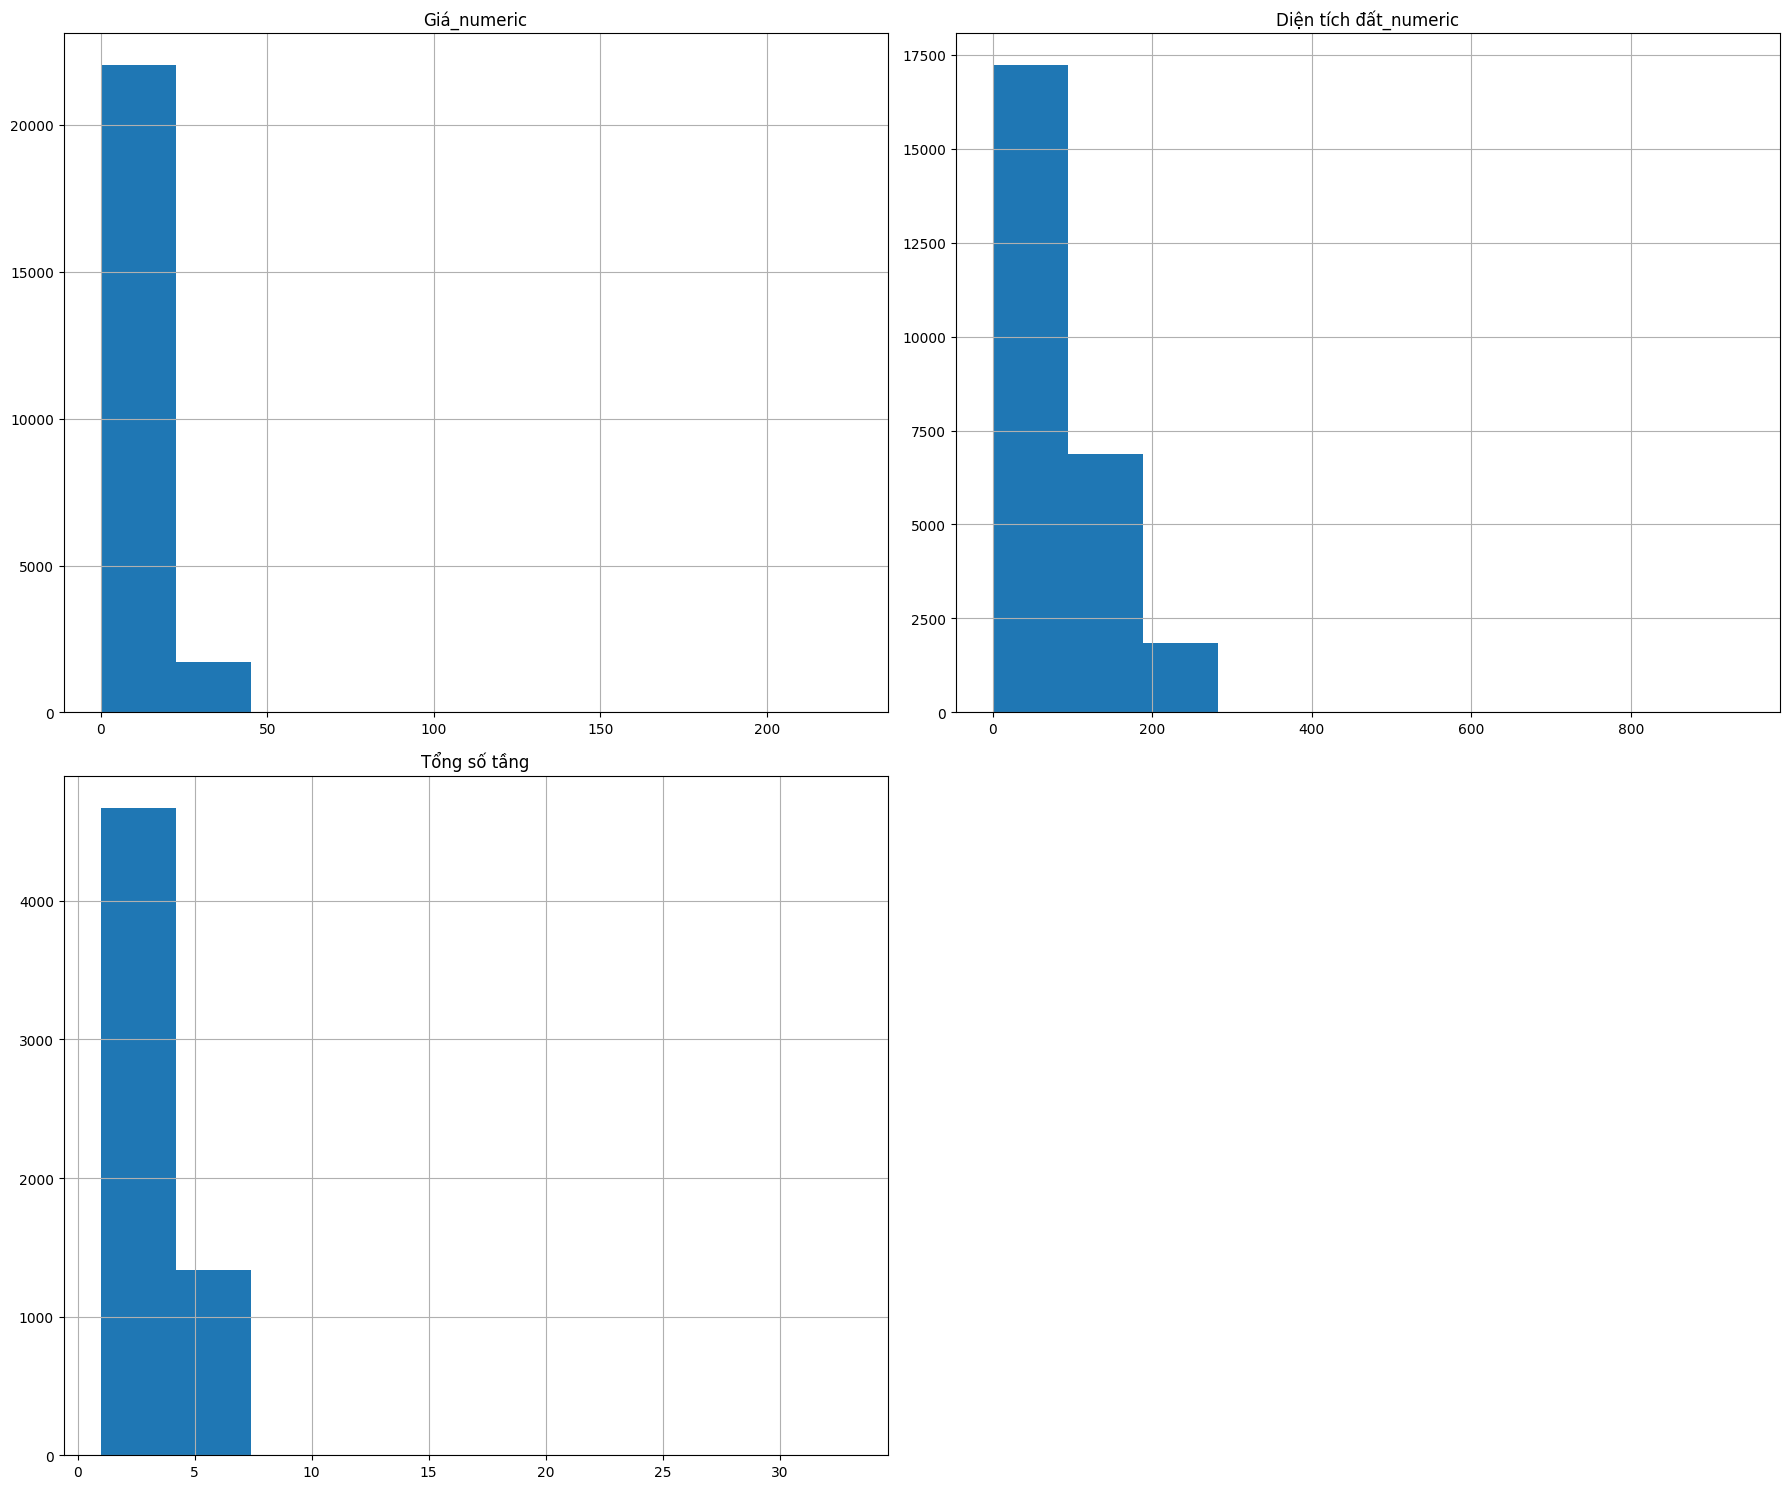

In [ ]:
# Vẽ biểu đồ phân bố dữ liệu
plt.figure(figsize=(18,15))
data[numeric_columns].hist(figsize=(18,15))
plt.tight_layout()
plt.show()

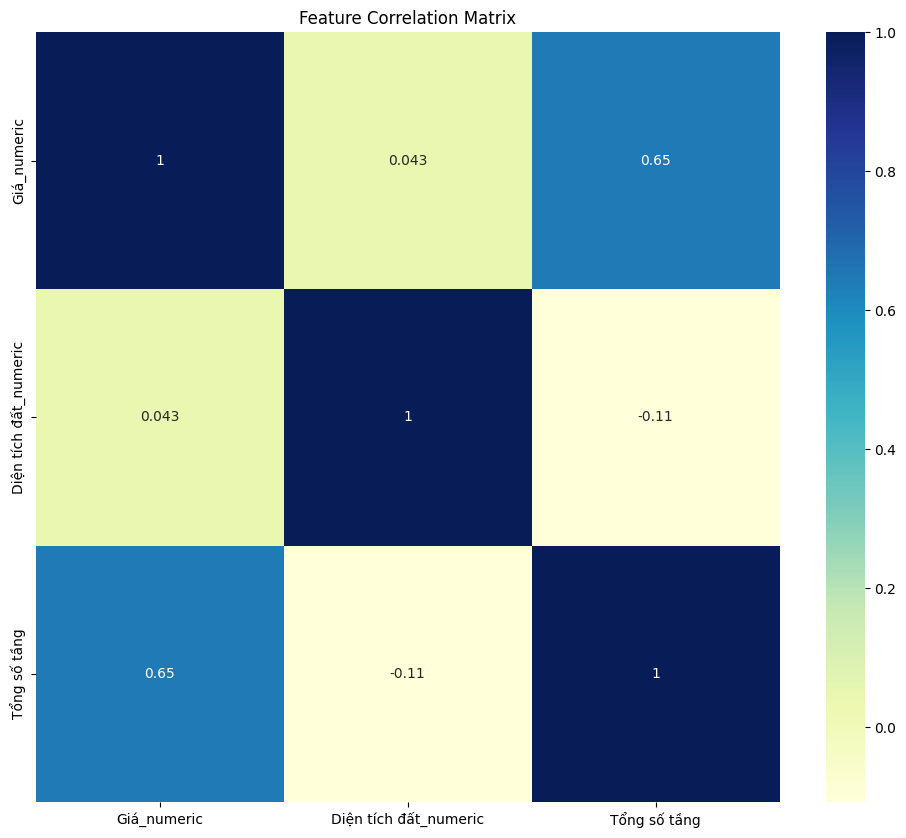

In [16]:
# Vẽ biểu đồ ma trận tương quan giữa các đặc trưng
plt.figure(figsize=(12,10))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='YlGnBu')
plt.title('Feature Correlation Matrix')
plt.show()

In [17]:
# Xác định giá trị trung vị của giá để làm biến mục tiêu
median_price = data['Giá_numeric'].median()
print(f"Median price: {median_price} billion VND")
data['AboveMedianPrice'] = (data['Giá_numeric'] > median_price).astype(int)  # Gán nhãn 1 nếu giá cao hơn trung vị


Median price: 4.66 billion VND


In [18]:
# Chuẩn bị dữ liệu để huấn luyện mô hình
X = data[numeric_columns]  # Đầu vào
y = data['AboveMedianPrice']  # Nhãn


In [19]:
# Xử lý các giá trị bị thiếu bằng cách thay thế bằng trung bình
X = X.fillna(X.mean())

In [20]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
# Huấn luyện mô hình Random Forest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=20, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [22]:
# Đánh giá độ chính xác của mô hình
accuracy = forest.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.999616122840691


In [ ]:
# Dự đoán trên tập kiểm tra
predictions = forest.predict(X_test)

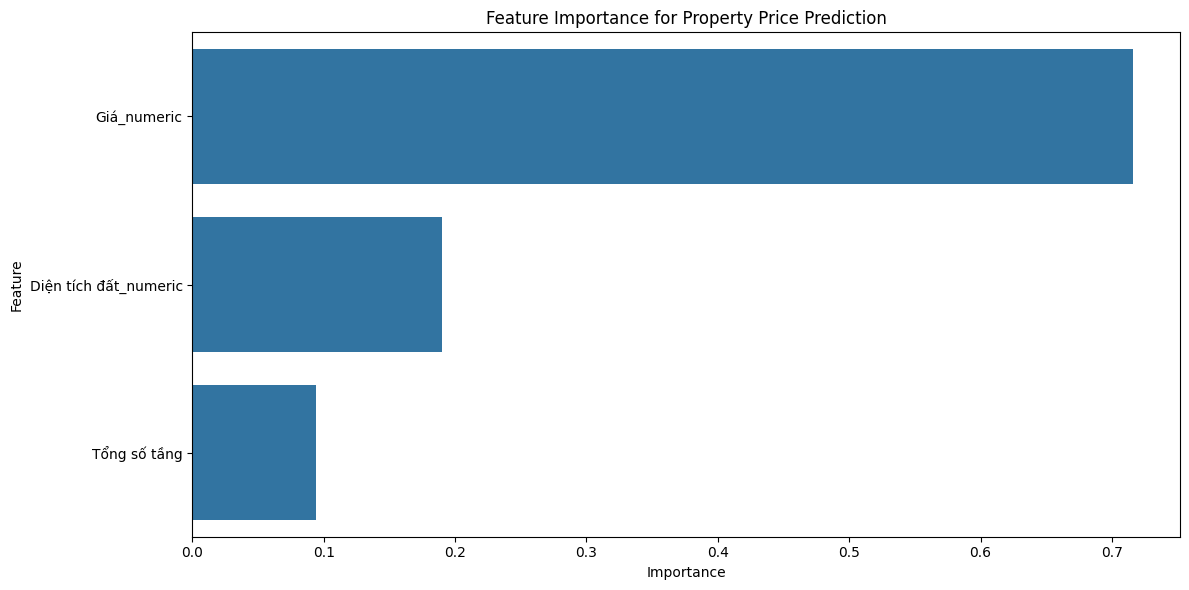

In [24]:
# Biểu đồ tầm quan trọng của các đặc trưng
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame(
    {'Feature': X.columns, 'Importance': forest.feature_importances_}
).sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Property Price Prediction')
plt.tight_layout()
plt.show()

In [25]:
# Hiển thị một số kết quả dự đoán
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})
print(results.head(10))

       Actual  Predicted
7792        0          0
10861       0          0
1668        0          0
21276       1          1
6876        0          0
22137       0          0
196         1          1
17511       1          1
21944       0          0
8255        1          1
